## Library

In [3]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

##Data Preparation

In [4]:
# Load the dataset
df = pd.read_csv('market_basket.csv')

# Remove completely empty rows
df.dropna(how='all', inplace=True)

# Convert each row into a list of items (excluding NaNs)
transactions = df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()

# Transform into one-hot encoded format
te = TransactionEncoder()
te_array = te.fit_transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Create a DataFrame for use with Apriori
basket_df = pd.DataFrame(te_array, columns=te.columns_)

# Preview the basket data
basket_df.head()

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Questions about the dataset

###Question 1

<Axes: title={'center': 'Top Items in High-Value Baskets'}>

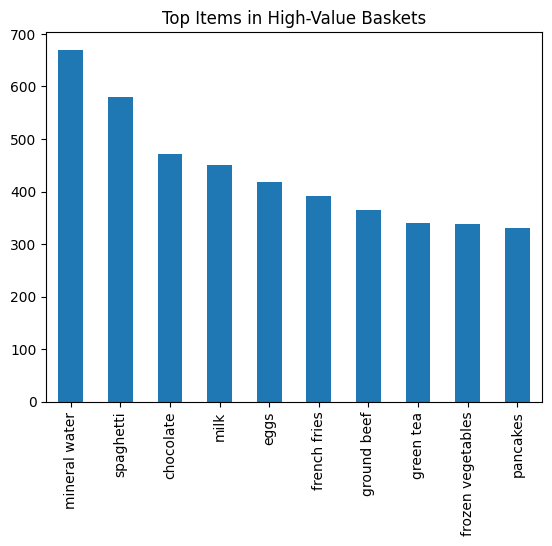

In [5]:
# 1. Which items often appear in high-value baskets?
# Count number of items per basket (row)
basket_df['total_items'] = basket_df.sum(axis=1)

# Identify high-value baskets (more than 6 items)
high_value = basket_df[basket_df['total_items'] > 6].drop(columns='total_items')

# Sum item counts and sort
high_value_items = high_value.sum().sort_values(ascending=False)

# Show top 10
high_value_items.head(10).plot(kind='bar', title='Top Items in High-Value Baskets')

###Question 2

In [6]:
# 2. Which products are common in low-value but rare in high-value, and vice versa?
# Low-value baskets (< 6 items)
# Count number of items in each basket
basket_df['total_items'] = basket_df.sum(axis=1)

# Create high and low-value basket sets
high_value = basket_df[basket_df['total_items'] > 6].drop(columns='total_items')
low_value = basket_df[basket_df['total_items'] < 6].drop(columns='total_items')

# Compute frequency (as percentage of transactions) for each item
low_freq = low_value.sum() / len(low_value)
high_freq = high_value.sum() / len(high_value)

# Combine into a comparison DataFrame
comparison = pd.DataFrame({
    'low_value_freq': low_freq,
    'high_value_freq': high_freq
})

# Set visibility thresholds
low_common = (comparison['low_value_freq'] > 0.05) & (comparison['high_value_freq'] < 0.01)
high_common = (comparison['high_value_freq'] > 0.05) & (comparison['low_value_freq'] < 0.01)

# Extract contrasting items
low_only = comparison[low_common].sort_values(by='low_value_freq', ascending=False)
high_only = comparison[high_common].sort_values(by='high_value_freq', ascending=False)

# Display the results
print("Items common in low-value baskets but rare in high-value baskets:")
display(low_only.head(10))

print("\nItems common in high-value baskets but rare in low-value baskets:")
display(high_only.head(10))

Items common in low-value baskets but rare in high-value baskets:


,low_value_freq,high_value_freq



Items common in high-value baskets but rare in low-value baskets:


,low_value_freq,high_value_freq
cooking oil,0.008676,0.095096
soup,0.008997,0.093600
avocado,0.009961,0.057715
butter,0.008355,0.055323
tomato juice,0.007069,0.055024
whole wheat pasta,0.007391,0.053828


###Question 3

<Axes: title={'center': 'Items Bought With Milk'}>

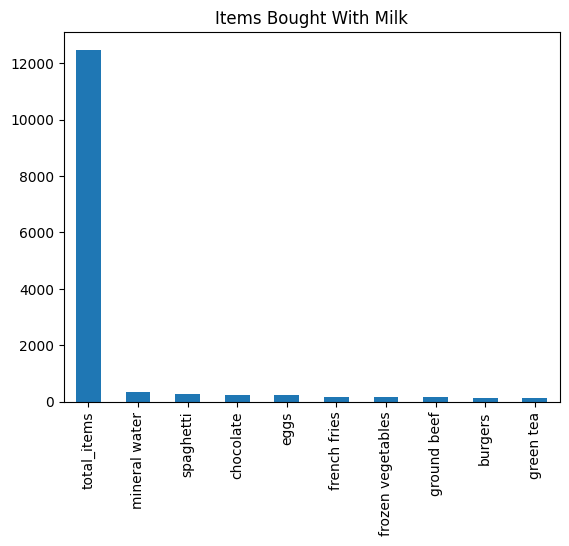

In [7]:
# 3. What products are typically bought with milk?
# Transactions with milk
milk_baskets = basket_df[basket_df['milk'] == True]

# Drop milk column to avoid bias
milk_baskets = milk_baskets.drop(columns='milk')

# Count co-occurring items
milk_related = milk_baskets.sum().sort_values(ascending=False)

# Show top 10
milk_related.head(10).plot(kind='bar', title='Items Bought With Milk')

###Question 4

In [8]:
# 4. Is milk more common in high or low-value baskets?
milk_high = high_value['milk'].sum()
milk_low = low_value['milk'].sum()

print(f"Milk in high-value baskets: {milk_high}")
print(f"Milk in low-value baskets: {milk_low}")

Milk in high-value baskets: 755
Milk in low-value baskets: 118


##Model Generation

In [9]:
# Define 3 Configurations
# Configurations: support, confidence, lift
configs = [
    {'min_support': 0.01, 'min_confidence': 0.3, 'min_lift': 2, 'name': 'Config 1'},
    {'min_support': 0.005, 'min_confidence': 0.2, 'min_lift': 2, 'name': 'Config 2'},
    {'min_support': 0.02, 'min_confidence': 0.4, 'min_lift': 3, 'name': 'Config 3'}
]

In [10]:
# Apriori for each Config
frequent_itemsets_list = []
rules_list = []

for config in configs:

    # Generate frequent itemsets
    freq_items = apriori(basket_df.drop(columns='total_items'),
                         min_support=config['min_support'],
                         use_colnames=True)

    # Generate rules
    rules = association_rules(freq_items,
                              metric="confidence",
                              min_threshold=config['min_confidence'])

    # Filter by lift
    rules = rules[rules['lift'] >= config['min_lift']]

    # Store results
    frequent_itemsets_list.append(freq_items)
    rules_list.append(rules)

In [11]:
# Filter for level 2 itemsets (itemsets containing exactly 2 items)
for config, freq_items in zip(configs, frequent_itemsets_list):
    print(f"------ {config['name']} ------")

# Display the filtered itemsets
    level_2_itemsets = freq_items[
        freq_items['itemsets'].apply(lambda x: len(x) == 2)
    ]

    print(f"Level 2 Frequent Itemsets (n={level_2_itemsets.shape[0]}):")
    display(level_2_itemsets)

------ Config 1 ------
Level 2 Frequent Itemsets (n=167):


,support,itemsets
75,0.011467,"(avocado, mineral water)"
76,0.011467,"(burgers, cake)"
77,0.017067,"(chocolate, burgers)"
78,0.028800,"(burgers, eggs)"
79,0.022000,"(burgers, french fries)"
...,...,...
237,0.011200,"(tomatoes, shrimp)"
238,0.014267,"(spaghetti, soup)"
239,0.020933,"(tomatoes, spaghetti)"
240,0.016533,"(spaghetti, turkey)"


------ Config 2 ------
Level 2 Frequent Itemsets (n=447):


,support,itemsets
101,0.005200,"(burgers, almonds)"
102,0.006000,"(chocolate, almonds)"
103,0.006533,"(almonds, eggs)"
104,0.005200,"(milk, almonds)"
105,0.007467,"(mineral water, almonds)"
...,...,...
543,0.008800,"(spaghetti, whole wheat pasta)"
544,0.014133,"(spaghetti, whole wheat rice)"
545,0.006533,"(tomatoes, turkey)"
546,0.006000,"(tomatoes, whole wheat rice)"


------ Config 3 ------
Level 2 Frequent Itemsets (n=51):


,support,itemsets
53,0.028800,"(burgers, eggs)"
54,0.022000,"(burgers, french fries)"
55,0.024400,"(burgers, mineral water)"
56,0.021467,"(spaghetti, burgers)"
57,0.027467,"(mineral water, cake)"
58,0.022800,"(mineral water, chicken)"
59,0.033200,"(chocolate, eggs)"
60,0.034400,"(chocolate, french fries)"
61,0.022933,"(chocolate, frozen vegetables)"
62,0.023467,"(chocolate, green tea)"


In [12]:
# Filter for level 3 itemsets (itemsets containing exactly 3 items)
for config, freq_items in zip(configs, frequent_itemsets_list):
    print(f"------ {config['name']} ------")

# Display the filtered itemsets
    level_3_itemsets = freq_items[
        freq_items['itemsets'].apply(lambda x: len(x) == 3)
    ]

    print(f"Level 3 Frequent Itemsets (n={level_3_itemsets.shape[0]}):")
    display(level_3_itemsets)

------ Config 1 ------
Level 3 Frequent Itemsets (n=17):


,support,itemsets
242,0.013467,"(chocolate, mineral water, eggs)"
243,0.010533,"(chocolate, spaghetti, eggs)"
244,0.010933,"(chocolate, mineral water, ground beef)"
245,0.014000,"(chocolate, milk, mineral water)"
246,0.010933,"(chocolate, spaghetti, milk)"
247,0.015867,"(chocolate, spaghetti, mineral water)"
248,0.010133,"(ground beef, mineral water, eggs)"
249,0.013067,"(milk, mineral water, eggs)"
250,0.014267,"(spaghetti, mineral water, eggs)"
251,0.010133,"(french fries, spaghetti, mineral water)"


------ Config 2 ------
Level 3 Frequent Itemsets (n=173):


,support,itemsets
548,0.005467,"(chocolate, burgers, eggs)"
549,0.005467,"(chocolate, milk, burgers)"
550,0.005733,"(chocolate, burgers, mineral water)"
551,0.006400,"(chocolate, spaghetti, burgers)"
552,0.009067,"(burgers, french fries, eggs)"
...,...,...
716,0.007467,"(spaghetti, mineral water, soup)"
717,0.009333,"(tomatoes, spaghetti, mineral water)"
718,0.006400,"(spaghetti, mineral water, turkey)"
719,0.006267,"(spaghetti, mineral water, whole wheat rice)"


------ Config 3 ------
Level 3 Frequent Itemsets (n=0):


,support,itemsets


In [13]:
# Filter for level 4 itemsets (itemsets containing exactly 4 items)
for config, freq_items in zip(configs, frequent_itemsets_list):
    print(f"------ {config['name']} ------")

# Display the filtered itemsets
    level_4_itemsets = freq_items[
        freq_items['itemsets'].apply(lambda x: len(x) == 4)
    ]

    print(f"Level 4 Frequent Itemsets (n={level_4_itemsets.shape[0]}):")
    display(level_4_itemsets)

------ Config 1 ------
Level 4 Frequent Itemsets (n=0):


,support,itemsets


------ Config 2 ------
Level 4 Frequent Itemsets (n=0):


,support,itemsets


------ Config 3 ------
Level 4 Frequent Itemsets (n=0):


,support,itemsets


##Best Configuration

In [14]:
# View High-Confidence Rules from Best Config
# Use the best-performing config (Config 2)
best_rules = rules_list[1]

# Show top rules sorted by confidence
top_rules = best_rules.sort_values(by='confidence', ascending=False)
top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)

,antecedents,consequents,support,confidence,lift
488,"(soup, frozen vegetables)",(mineral water),0.005067,0.633333,2.658086
575,"(soup, olive oil)",(mineral water),0.005200,0.582090,2.443017
482,"(olive oil, frozen vegetables)",(mineral water),0.006533,0.576471,2.419434
558,"(milk, soup)",(mineral water),0.008533,0.561404,2.356198
366,"(chocolate, soup)",(mineral water),0.005600,0.552632,2.319383
380,"(eggs, cooking oil)",(mineral water),0.006400,0.545455,2.289261
471,"(ground beef, frozen vegetables)",(mineral water),0.009200,0.543307,2.280248
565,"(milk, turkey)",(mineral water),0.006133,0.541176,2.271306
584,"(spaghetti, soup)",(mineral water),0.007467,0.523364,2.196549
545,"(shrimp, ground beef)",(spaghetti),0.006000,0.523256,3.004915


In [15]:
# Filter & View Milk-Related Rules
# Find rules where milk is in antecedent or consequent
milk_rules = best_rules[
    best_rules['antecedents'].apply(lambda x: 'milk' in x) |
    best_rules['consequents'].apply(lambda x: 'milk' in x)
]

# Display top milk-related rules
milk_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='confidence', ascending=False).head(5)

,antecedents,consequents,support,confidence,lift
558,"(milk, soup)",(mineral water),0.008533,0.561404,2.356198
565,"(milk, turkey)",(mineral water),0.006133,0.541176,2.271306
522,"(milk, ground beef)",(mineral water),0.011067,0.503030,2.111207
552,"(milk, olive oil)",(mineral water),0.008533,0.500000,2.098489
267,"(milk, cake)",(mineral water),0.006400,0.480000,2.014550


##Configuration 1 rules

In [16]:
# View High-Confidence Rules from Config 1
config1_rules = rules_list[0]

# Show top rules sorted by confidence
one_rules = config1_rules.sort_values(by='confidence', ascending=False)
one_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)

,antecedents,consequents,support,confidence,lift
45,"(eggs, ground beef)",(mineral water),0.010133,0.506667,2.126469
54,"(milk, ground beef)",(mineral water),0.011067,0.503030,2.111207
56,"(mineral water, ground beef)",(spaghetti),0.017067,0.416938,2.394361
16,(ground beef),(spaghetti),0.039200,0.398915,2.290857
60,"(mineral water, olive oil)",(spaghetti),0.010267,0.373786,2.146553
34,(red wine),(spaghetti),0.010267,0.364929,2.095687
33,(olive oil),(spaghetti),0.022933,0.348884,2.003547
14,(herb & pepper),(ground beef),0.016000,0.323450,3.291555
51,"(mineral water, frozen vegetables)",(milk),0.011067,0.309701,2.389672
22,(soup),(milk),0.015200,0.300792,2.320923


In [17]:
# Filter & View Milk-Related Rules
# Find rules where milk is in antecedent or consequent
milk_rules_config1 = config1_rules[
    config1_rules['antecedents'].apply(lambda x: 'milk' in x) |
    config1_rules['consequents'].apply(lambda x: 'milk' in x)
]

# Display top milk-related rules
milk_rules_config1[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='confidence', ascending=False).head(5)

,antecedents,consequents,support,confidence,lift
54,"(milk, ground beef)",(mineral water),0.011067,0.503030,2.111207
51,"(mineral water, frozen vegetables)",(milk),0.011067,0.309701,2.389672
22,(soup),(milk),0.015200,0.300792,2.320923


##Visualization of the rules

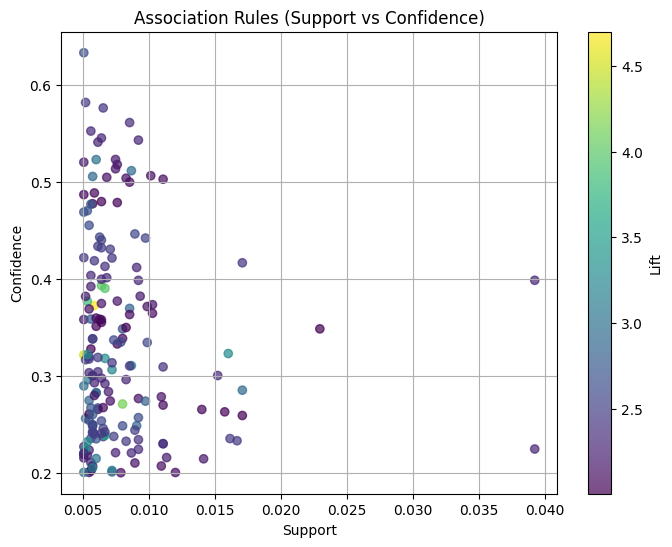

In [18]:
# Visualize Rules (Lift vs Confidence)

plt.figure(figsize=(8,6))
plt.scatter(best_rules['support'], best_rules['confidence'], c=best_rules['lift'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Lift')
plt.title('Association Rules (Support vs Confidence)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

In [19]:
# Total of rules found

frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

print(f"Total rules found: {len(rules)}")
rules.head()

Total rules found: 1826


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(burgers),(almonds),0.087200,0.020267,0.005200,0.059633,2.942419,1.0,0.003433,1.041863,0.723207,0.050847,0.040181,0.158106
1,(almonds),(burgers),0.020267,0.087200,0.005200,0.256579,2.942419,1.0,0.003433,1.227837,0.673799,0.050847,0.185560,0.158106
2,(chocolate),(almonds),0.163867,0.020267,0.006000,0.036615,1.806668,1.0,0.002679,1.016970,0.534000,0.033683,0.016687,0.166334
3,(almonds),(chocolate),0.020267,0.163867,0.006000,0.296053,1.806668,1.0,0.002679,1.187778,0.455731,0.033683,0.158092,0.166334
4,(almonds),(eggs),0.020267,0.179733,0.006533,0.322368,1.793593,1.0,0.002891,1.210491,0.451613,0.033770,0.173889,0.179359


/tmp/ipython-input-20-3828012133.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lift', y='rule', data=top_rules, palette='viridis')


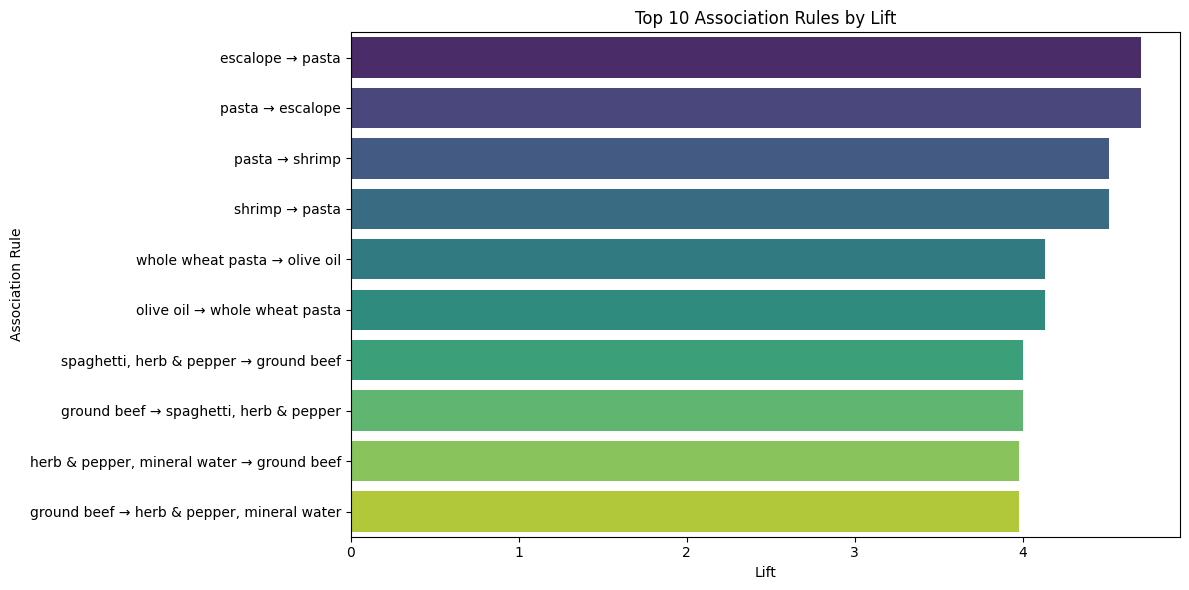

In [20]:
# Makes sure lift is numeric
rules['lift'] = pd.to_numeric(rules['lift'], errors='coerce')

# Creates a readable string for each rule
rules['rule'] = rules['antecedents'].apply(lambda x: ', '.join(list(x))) + " → " + rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Gets top 10 rules by lift
top_rules = rules.nlargest(10, 'lift')[['rule', 'lift']]

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='lift', y='rule', data=top_rules, palette='viridis')
plt.xlabel('Lift')
plt.ylabel('Association Rule')
plt.title('Top 10 Association Rules by Lift')
plt.tight_layout()
plt.show()

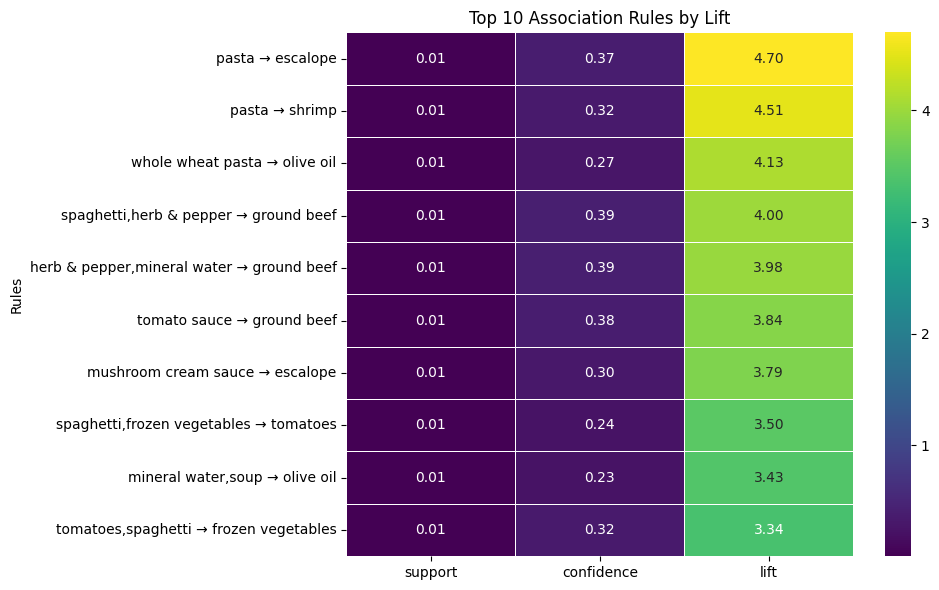

In [21]:
top_rules = best_rules.sort_values('lift', ascending=False).head(10).copy()

top_rules['rule'] = top_rules['antecedents'].apply(lambda s: ','.join(s)) + ' → ' + \
                    top_rules['consequents'].apply(lambda s: ','.join(s))

# Heatmap matrix
heatmap_data = top_rules.set_index('rule')[['support','confidence','lift']]

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap='viridis')
plt.title('Top 10 Association Rules by Lift')
plt.ylabel('Rules')
plt.tight_layout()
plt.show()